In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression




In [41]:
# ========== 1. Load the dataset ==========
file_path = "cleaned_units_project_data.csv"  # Change to your actual file path
df = pd.read_csv(file_path)



/var/folders/3w/wfm3gqnj2pj95kb0_6m_klmc0000gn/T/ipykernel_71670/1985576198.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [43]:
# ========== 2. Handle Missing Values ==========
# Replace -999.00 with NaN (common placeholder for missing values)
df.replace(-999.00, np.nan, inplace=True)

# Select only numeric columns (ignore categorical ones)
numeric_df = df.select_dtypes(include=[np.number])

# Drop flag columns (used for data quality indicators, not for prediction)
flag_columns = [col for col in numeric_df.columns if "_flag" in col]
numeric_df = numeric_df.drop(columns=flag_columns, errors="ignore")


In [45]:
numeric_df

,Accession,Profile_number,Cast_number,Niskin_ID,Sample_ID,Year_UTC,Month_UTC,Day_UTC,Time_UTC,Latitude,...,Aragonite,Calcite,Revelle_Factor,Silicate,Phosphate,Nitrate,Nitrite,Nitrate_and_Nitrite,recommended_Nitrate_and_Nitrite,Ammonium
0,144549,1,5.0,1.0,10501,2008,4,1,0.446238,56.5090,...,1.20,1.91,16.20,50.8,1.98,25.8,0.19,25.99,25.99,0.14
1,144549,1,5.0,2.0,10502,2008,4,1,0.446238,56.5090,...,1.26,2.00,15.86,50.0,1.96,25.6,0.20,25.80,25.80,0.13
2,144549,1,5.0,3.0,10503,2008,4,1,0.446238,56.5090,...,1.35,2.15,15.35,45.6,1.87,24.0,0.15,24.15,24.15,0.41
3,144549,1,5.0,4.0,10504,2008,4,1,0.446238,56.5090,...,1.37,2.19,15.22,43.1,1.79,22.6,0.17,22.77,22.77,NaN
4,144549,1,5.0,5.0,10505,2008,4,1,0.446238,56.5090,...,1.30,2.08,15.60,40.9,1.72,21.5,0.16,21.66,21.66,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28200,208230,3391,1.0,7.0,464,2017,9,28,0.691123,44.1972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28201,208230,3391,1.0,8.0,465,2017,9,28,0.691678,44.1970,...,2.09,3.27,12.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28202,208230,3391,1.0,9.0,466,2017,9,28,0.692072,44.1970,...,2.18,3.40,11.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28203,208230,3391,1.0,10.0,467,2017,9,28,0.692396,44.1968,...,2.19,3.42,11.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# Impute missing values with median
imputer = SimpleImputer(strategy="median")
numeric_df_imputed = pd.DataFrame(imputer.fit_transform(numeric_df), columns=numeric_df.columns)


In [49]:
# ========== 3. Correlation Analysis with pH ==========
correlation_matrix = numeric_df_imputed.corr()
ph_correlation = correlation_matrix["pH_TS_measured"].sort_values(ascending=False)

In [51]:
# Select top 15 most correlated features
top_corr_features = ph_correlation[1:16]

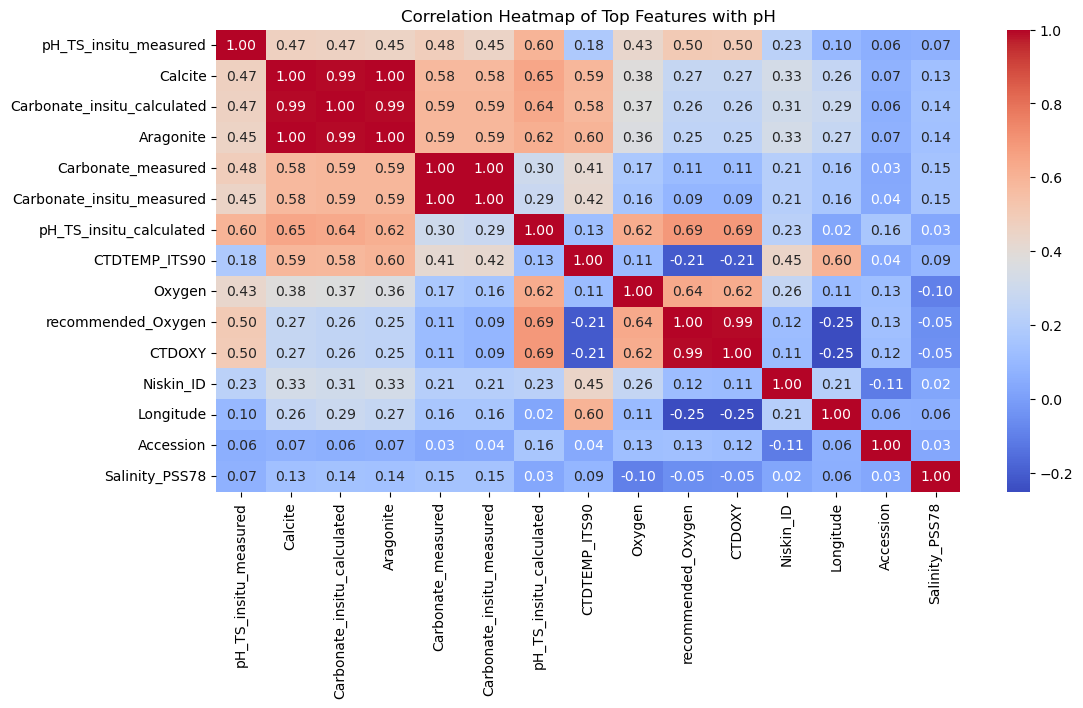

In [53]:
# Plot heatmap of top correlated features
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix.loc[top_corr_features.index, top_corr_features.index], 
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Top Features with pH")
plt.show()

In [54]:
# ========== 4. Feature Importance Using Random Forest ==========
# Define features (X) and target (y)
X = numeric_df_imputed.drop(columns=["pH_TS_measured"], errors="ignore")
y = numeric_df_imputed["pH_TS_measured"]

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

RandomForestRegressor(random_state=42)

/var/folders/3w/wfm3gqnj2pj95kb0_6m_klmc0000gn/T/ipykernel_71670/1656284203.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance[:15].values, y=feature_importance[:15].index, palette="viridis")


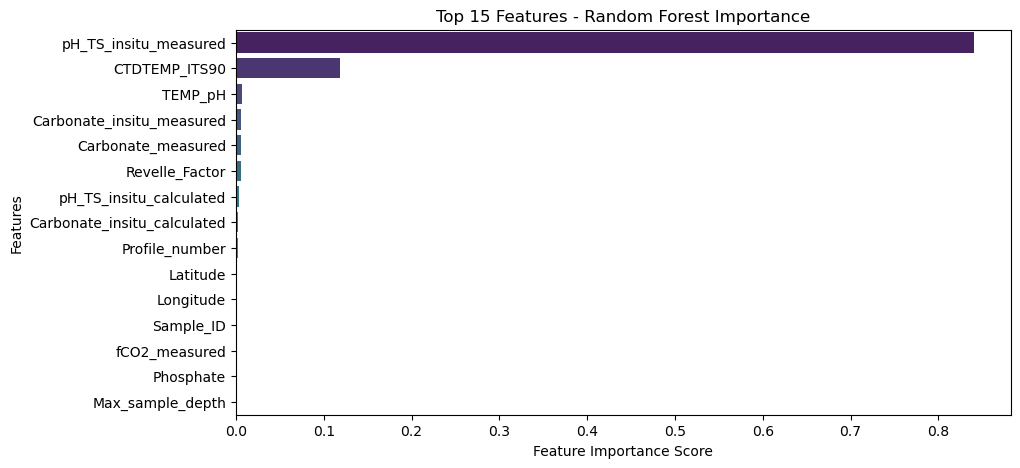

In [56]:
# Compute feature importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot top 15 features based on Random Forest
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance[:15].values, y=feature_importance[:15].index, palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 15 Features - Random Forest Importance")
plt.show()


/var/folders/3w/wfm3gqnj2pj95kb0_6m_klmc0000gn/T/ipykernel_71670/1321578888.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_series[:15].values, y=mi_series[:15].index, palette="magma")


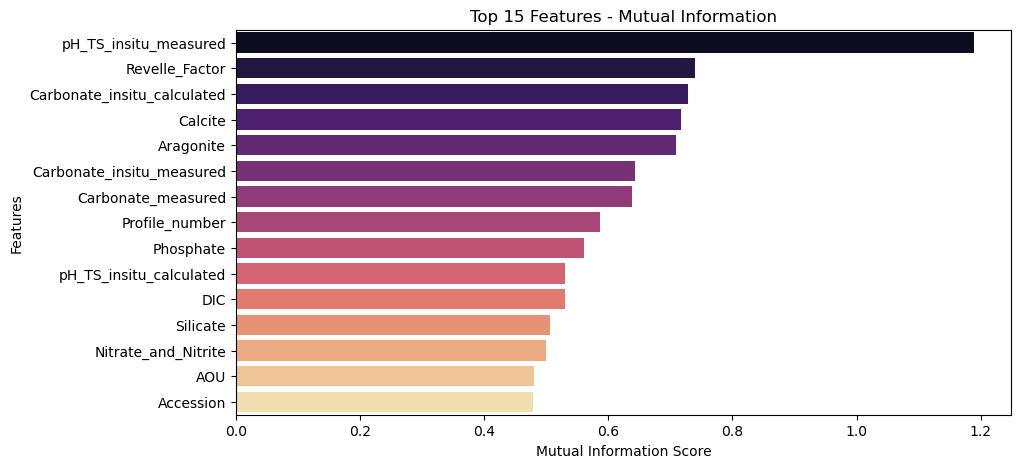

In [57]:
# ========== 5. Feature Importance Using Mutual Information ==========
mi_scores = mutual_info_regression(X, y)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Plot top 15 features based on Mutual Information
plt.figure(figsize=(10, 5))
sns.barplot(x=mi_series[:15].values, y=mi_series[:15].index, palette="magma")
plt.xlabel("Mutual Information Score")
plt.ylabel("Features")
plt.title("Top 15 Features - Mutual Information")
plt.show()



In [58]:
# Print Top 15 Features from Both Methods
print("\n🔹 Top 15 Features by Correlation:")
print(top_corr_features)

print("\n🔹 Top 15 Features by Random Forest Importance:")
print(feature_importance[:15])

print("\n🔹 Top 15 Features by Mutual Information:")
print(mi_series[:15])


🔹 Top 15 Features by Correlation:
pH_TS_insitu_measured          0.877345
Calcite                        0.673492
Carbonate_insitu_calculated    0.671383
Aragonite                      0.670737
Carbonate_measured             0.670183
Carbonate_insitu_measured      0.650840
pH_TS_insitu_calculated        0.536668
CTDTEMP_ITS90                  0.431362
Oxygen                         0.346597
recommended_Oxygen             0.336736
CTDOXY                         0.334987
Niskin_ID                      0.258402
Longitude                      0.213250
Accession                      0.100117
Salinity_PSS78                 0.097423
Name: pH_TS_measured, dtype: float64

🔹 Top 15 Features by Random Forest Importance:
pH_TS_insitu_measured          0.840450
CTDTEMP_ITS90                  0.118751
TEMP_pH                        0.007497
Carbonate_insitu_measured      0.006235
Carbonate_measured             0.005653
Revelle_Factor                 0.005449
pH_TS_insitu_calculated        0.003958


In [59]:
from sklearn.model_selection import train_test_split

# Define selected features from importance analysis
selected_features = [
    "pH_TS_insitu_measured", "Calcite", "Carbonate_insitu_calculated", "Aragonite", 
    "Carbonate_measured", "Carbonate_insitu_measured", "pH_TS_insitu_calculated", 
    "CTDTEMP_ITS90", "Oxygen", "recommended_Oxygen", "CTDOXY", "Niskin_ID", 
    "Longitude", "Accession", "Salinity_PSS78"
]

# Ensure only selected features and target are used
df_model = df[selected_features + ["pH_TS_measured"]]

# Handle missing values (impute with median)
df_model.fillna(df_model.median(), inplace=True)

# Split into train and test sets (80% train, 20% test)
X = df_model.drop(columns=["pH_TS_measured"])
y = df_model["pH_TS_measured"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Data Preparation Complete! Ready for Model Training.")


✅ Data Preparation Complete! Ready for Model Training.


/var/folders/3w/wfm3gqnj2pj95kb0_6m_klmc0000gn/T/ipykernel_71670/3685598773.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.fillna(df_model.median(), inplace=True)


In [60]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Initialize models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
svr = SVR(kernel='rbf')

# Train models
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)
svr.fit(X_train, y_train)

# Make predictions
rf_preds = rf.predict(X_test)
gb_preds = gb.predict(X_test)
svr_preds = svr.predict(X_test)

# Evaluate models
def evaluate(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"📊 {model_name}: MSE = {mse:.4f}, R² = {r2:.4f}")

evaluate(y_test, rf_preds, "Random Forest")
evaluate(y_test, gb_preds, "Gradient Boosting")
evaluate(y_test, svr_preds, "SVM Regression")


📊 Random Forest: MSE = 0.0001, R² = 0.9927
📊 Gradient Boosting: MSE = 0.0003, R² = 0.9855
📊 SVM Regression: MSE = 0.0204, R² = -0.0037


In [61]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

# Define base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
]

# Meta-model (final predictor)
meta_model = Ridge(alpha=1.0)

# Create stacking ensemble
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Train ensemble model
stacking_model.fit(X_train, y_train)

# Predictions and evaluation
stacking_preds = stacking_model.predict(X_test)
evaluate(y_test, stacking_preds, "Stacking Ensemble")


📊 Stacking Ensemble: MSE = 0.0001, R² = 0.9930


In [62]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest and Gradient Boosting
rf_params = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [10, 20, None]
}

gb_params = {
    'gb__n_estimators': [100, 200],
    'gb__learning_rate': [0.05, 0.1, 0.2]
}

# Merge parameters
param_grid = {**rf_params, **gb_params}

# GridSearchCV for tuning
grid_search = GridSearchCV(stacking_model, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best R² Score:", grid_search.best_score_)

# Evaluate tuned model
best_model = grid_search.best_estimator_
stacking_preds_tuned = best_model.predict(X_test)
evaluate(y_test, stacking_preds_tuned, "Tuned Stacking Ensemble")


Best Parameters: {'gb__learning_rate': 0.2, 'gb__n_estimators': 200, 'rf__max_depth': None, 'rf__n_estimators': 100}
Best R² Score: 0.9959340132765708
📊 Tuned Stacking Ensemble: MSE = 0.0001, R² = 0.9946


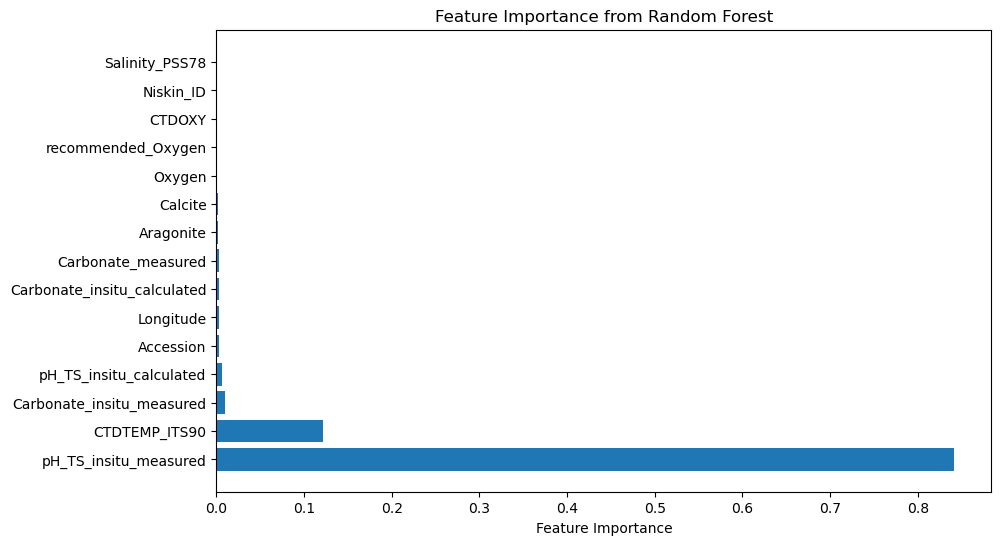

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance from the best model (Random Forest inside the Stacking model)
feature_importance = best_model.named_estimators_['rf'].feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
features = X_train.columns

# Plot importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(features)), np.array(features)[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance from Random Forest")
plt.show()

In [64]:
import joblib

# Save model
joblib.dump(best_model, "ocean_acidification_model.pkl")
print("✅ Model Saved as ocean_acidification_model.pkl")

✅ Model Saved as ocean_acidification_model.pkl


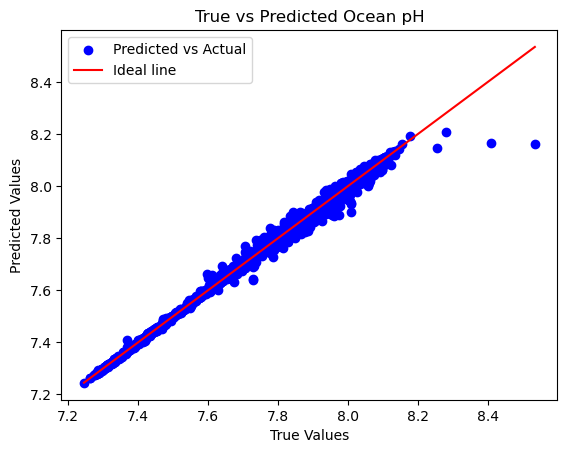

In [79]:
import matplotlib.pyplot as plt

# Compare true values vs predicted
plt.scatter(y_test, stacking_preds_tuned, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Ocean pH')
plt.legend()
plt.show()


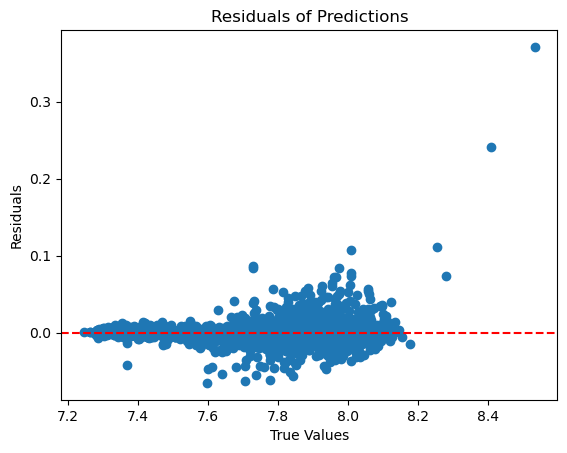

In [83]:
residuals = y_test - stacking_preds_tuned

plt.scatter(y_test, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions')
plt.show()
